## Classification

### Before we start

We first need to go over the dependencies needed for this notebook to function properly.

We will use the following libraries:

- `pandas` for data manipulation
- `numpy` for numerical operations
- `matplotlib` for visualization
---
- `json` for JSON manipulation
---
- `sklearn` for the Machine Learning algorithms, metrics and useful visualization tools such as t-SNE
- `optuna` for hyperparameter tuning
- `tensorflow` for the neural network model
- `keras` for the neural network model
- `tensorflow_docs` for the visualization tools used in the neural network model
- `catboost` for the CatBoost model
---
- `chromadb` to retrieve the embeddings to a vector database

In [1]:
import chromadb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import catboost as cb
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from sklearn.multioutput import MultiOutputClassifier


Let's now retrieve the classification embeddings from the chromadb vector database and perform classification on them.

In [2]:
client = chromadb.PersistentClient(path="./chroma_db")
collection = client.get_collection("nomic_classification_v1")

Now let us get the words along with their classes and division and sections from the json file we created earlier.

In [3]:
with open("hierarchy.json", "r") as f:
    categories = json.load(f)

Let's retrieve the embeddings and the words along with the class, division, and section from the chromadb and create a dataframe with them.

In [4]:
# Retrieve the embeddings, words, and metadata
words = collection.get(include=["embeddings", "documents"])['documents']
embeddings = collection.get(include=["embeddings", "documents"])['embeddings']
metadata = collection.get(include=["embeddings", "documents", "metadatas"])['metadatas']

# Create a dataframe with the embeddings and the words
cls_df = pd.DataFrame({'word': words, 'embedding': embeddings})

# Add the class, division, and section from metadata to the dataframe
cls_df['class'] = [md['class'] for md in metadata]
cls_df['division'] = [md['division'] for md in metadata]
cls_df['section'] = [md['section'] for md in metadata]

cls_df

,word,embedding,class,division,section
0,Existence,"[-0.029754638671875, -0.0263671875, -0.0127792...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
1,Inexistence,"[-0.01029205322265625, 0.019256591796875, -0.0...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
2,Consanguinity,"[0.0386962890625, -0.01026153564453125, -0.013...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,RELATION
3,Trisection,"[0.007350921630859375, -0.001903533935546875, ...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,NUMBER
4,Innocence,"[0.0338134765625, 0.0139923095703125, -0.03097...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
...,...,...,...,...,...
1052,Knave,"[0.0032215118408203125, 0.01201629638671875, -...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
1053,Disinterestedness,"[-0.01776123046875, 0.020965576171875, -0.0221...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
1054,Selfishness,"[0.01071929931640625, 0.049468994140625, -0.03...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
1055,Virtue,"[0.0201416015625, 0.006626129150390625, -0.035...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS


In [5]:
# Get the number of classes
n_classes = cls_df['class'].nunique()

Now let's prepare the data for classification by converting the class, division, and section to numerical values.

In [6]:
# Make all classes and divisions/sections as numerical values
cls_df['class'] = pd.Categorical(cls_df['class'])
cls_df['division'] = pd.Categorical(cls_df['division'])
cls_df['section'] = pd.Categorical(cls_df['section'])

cls_df['class'] = cls_df['class'].cat.codes
cls_df['division'] = cls_df['division'].cat.codes
cls_df['section'] = cls_df['section'].cat.codes
cls_df

,word,embedding,class,division,section
0,Existence,"[-0.029754638671875, -0.0263671875, -0.0127792...",0,4,7
1,Inexistence,"[-0.01029205322265625, 0.019256591796875, -0.0...",0,4,7
2,Consanguinity,"[0.0386962890625, -0.01026153564453125, -0.013...",0,4,29
3,Trisection,"[0.007350921630859375, -0.001903533935546875, ...",0,4,19
4,Innocence,"[0.0338134765625, 0.0139923095703125, -0.03097...",4,4,16
...,...,...,...,...,...
1052,Knave,"[0.0032215118408203125, 0.01201629638671875, -...",4,4,16
1053,Disinterestedness,"[-0.01776123046875, 0.020965576171875, -0.0221...",4,4,16
1054,Selfishness,"[0.01071929931640625, 0.049468994140625, -0.03...",4,4,16
1055,Virtue,"[0.0201416015625, 0.006626129150390625, -0.035...",4,4,16


Easy to notice is that when the class has no division, the division is 4, which means `N/A` in our case.
This will become important later when we perform the two-level classification.

Let's also prepare the embeddings for classification by converting them to a numpy array.

In [7]:
X = np.vstack(cls_df['embedding'])

### Multi-class logistic regression

Let us start by training a multi-class logistic regression model on the embeddings and the class.

Before we do that, however, let's split the data into training and testing sets, using 80% of the data for training and 20% for testing.

In [8]:
y = cls_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11234)

Now let's train a logistic regression model on the training data and evaluate it on the testing data.

In [9]:
# Train a logistic regression model

model = LogisticRegression(max_iter=1000, multi_class='ovr' , n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr', n_jobs=-1, random_state=42)

In [10]:
# Generate classification report

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65        43
           1       0.73      0.61      0.67        31
           2       0.79      0.56      0.66        34
           3       0.70      0.73      0.72        26
           4       0.55      0.63      0.59        27
           5       0.66      0.75      0.70        51

    accuracy                           0.67       212
   macro avg       0.68      0.66      0.66       212
weighted avg       0.68      0.67      0.67       212


Having trained and evaluated the model, we can see that the model has an accuracy of 0.67, 
which is not bad considering the previous results we got from the clustering of the embeddings.

However, let's use a hyperparameter tuning library such as `optuna` to find the best hyperparameters for the model.

We will use the `cross_val_score` function from `sklearn` to evaluate the model using cross-validation and the `optuna` library to find the best hyperparameters for the model based on the maximization of the accuracy.

In [42]:
def objective(trial):
    # Define the hyperparameters to tune
    multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial'])
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)

    # Create logistic regression model with suggested hyperparameters
    model = LogisticRegression(C=C, random_state=42, max_iter=1000, multi_class=multi_class , n_jobs=-1)
    # Perform cross-validation and return the mean score
    score = cross_val_score(model, X, y, scoring='accuracy')
    return score.mean()


# Create a study object and specify the optimization direction
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Output the best hyperparameters
print('Best trial:', study.best_trial.params)

[I 2024-02-24 15:37:35,745] A new study created in memory with name: no-name-a6545a54-782a-4c8b-bd82-204da2c722dd
[W 2024-02-24 15:37:37,844] Trial 0 failed with parameters: {'multi_class': 'ovr', 'C': 1.035041618345576} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\panagiotis\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\panagiotis\AppData\Local\Temp\ipykernel_32352\3733145933.py", line 9, in objective
    score = cross_val_score(model, X, y, scoring='accuracy')
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\panagiotis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\panagiotis\AppData\Local\Programs\Py

KeyboardInterrupt: 

### Multi-class SVM

Let's now train a multi-class SVM model on the embeddings and the class.

In [43]:
svm_model = SVC(kernel='rbf', random_state=22)
svm_model.fit(X_train, y_train)

SVC(random_state=22)

In [44]:
# Generate classification report
y_pred = svm_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65        43
           1       0.78      0.68      0.72        31
           2       0.77      0.68      0.72        34
           3       0.69      0.77      0.73        26
           4       0.58      0.56      0.57        27
           5       0.70      0.78      0.74        51

    accuracy                           0.69       212
   macro avg       0.69      0.69      0.69       212
weighted avg       0.70      0.69      0.69       212


Let's use the `optuna` library to find the best hyperparameters for the model based on the maximization of the accuracy.


In [19]:
def objective(trial):
    # Hyperparameters to tune
    C = trial.suggest_float('C', 1e-5, 1e5, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # If kernel is 'poly', we also tune degree
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 1, 10)

    # Create and train the SVM model
    if kernel == 'poly':
        model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, random_state=22)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=22)

    score = cross_val_score(model, X, y, scoring='accuracy')
    return score.mean()


# Create a study object and specify the optimization direction
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Output the best hyperparameters
print('Best trial:', study.best_trial.params)

[I 2024-02-24 15:21:53,815] A new study created in memory with name: no-name-fbb0df03-3332-4ee6-88b9-63dab539915d
[I 2024-02-24 15:21:54,150] Trial 0 finished with value: 0.4844272556559063 and parameters: {'C': 7.601359404948779, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.4844272556559063.
[I 2024-02-24 15:21:54,670] Trial 1 finished with value: 0.21570240543682373 and parameters: {'C': 0.001925613168034482, 'kernel': 'poly', 'gamma': 'auto', 'degree': 4}. Best is trial 0 with value: 0.4844272556559063.
[I 2024-02-24 15:21:55,067] Trial 2 finished with value: 0.46643566127157293 and parameters: {'C': 24.637615145321337, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.4844272556559063.
[I 2024-02-24 15:21:55,604] Trial 3 finished with value: 0.425744433515157 and parameters: {'C': 6832.795980529893, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with value: 0.4844272556559063.
[I 2024-02-24 15:21:56,014] Trial 4 finished with value:

Best trial: {'C': 0.751796233971926, 'kernel': 'linear', 'gamma': 'scale'}


### Multi-class SGD

Let's now train a multi-class SGD model on the embeddings and the class.

In [45]:
sgd_model = SGDClassifier(loss='squared_hinge', max_iter=1000, n_jobs=-1, random_state=42,
                          penalty='l2', alpha=2.6545371602330262e-06,
                          learning_rate='adaptive', eta0=0.007698135990041223)
sgd_model.fit(X_train, y_train)

SGDClassifier(alpha=2.6545371602330262e-06, eta0=0.007698135990041223,
              learning_rate='adaptive', loss='squared_hinge', n_jobs=-1,
              random_state=42)

In [46]:
# Generate classification report
y_pred = sgd_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73        43
           1       0.73      0.71      0.72        31
           2       0.76      0.74      0.75        34
           3       0.67      0.69      0.68        26
           4       0.62      0.67      0.64        27
           5       0.72      0.76      0.74        51

    accuracy                           0.72       212
   macro avg       0.71      0.71      0.71       212
weighted avg       0.72      0.72      0.72       212


Let's use the `optuna` library to find the best hyperparameters for the model based on the maximization of the accuracy.

In [26]:
def objective(trial):
    # Hyperparameters to tune
    loss = trial.suggest_categorical('loss', ['hinge', 'log_loss', 'squared_hinge', 'perceptron'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive'])
    eta0 = trial.suggest_float('eta0', 1e-5, 1e-1, log=True)  # Only relevant for certain learning rates

    # Create and train the SGD Classifier
    model = SGDClassifier(loss=loss, penalty=penalty, alpha=alpha, learning_rate=learning_rate, eta0=eta0,
                          random_state=42)
    model.fit(X_train, y_train)

    # Perform cross-validation and return the mean score
    scores = cross_val_score(model, X_train, y_train, cv=5)  # cv=5 for 5-fold cross-validation
    return scores.mean()


# Create a study object and specify the optimization direction
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Adjust the number of trials as needed

# Best hyperparameters
print('Best trial:', study.best_trial.params)

[I 2024-02-24 15:24:16,607] A new study created in memory with name: no-name-92fe01f2-11bc-4229-83df-456aa2fb7503
[I 2024-02-24 15:24:17,084] Trial 0 finished with value: 0.6047337278106509 and parameters: {'loss': 'perceptron', 'penalty': 'l2', 'alpha': 5.849013687796652e-06, 'learning_rate': 'adaptive', 'eta0': 0.0013475657567535645}. Best is trial 0 with value: 0.6047337278106509.
[I 2024-02-24 15:24:17,609] Trial 1 finished with value: 0.4958579881656805 and parameters: {'loss': 'squared_hinge', 'penalty': 'l2', 'alpha': 0.02749692429366791, 'learning_rate': 'constant', 'eta0': 0.02176202623344909}. Best is trial 0 with value: 0.6047337278106509.
[I 2024-02-24 15:24:18,008] Trial 2 finished with value: 0.20946745562130178 and parameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 1.997101470441552e-05, 'learning_rate': 'invscaling', 'eta0': 0.00022191668819864202}. Best is trial 0 with value: 0.6047337278106509.
[I 2024-02-24 15:24:20,501] Trial 3 finished with value: 0

Best trial: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 1.7499949023290976e-05, 'learning_rate': 'adaptive', 'eta0': 0.03319923042456373}


We notice that the SGD model gave the best accuracy of 0.72, which is the highest among the models we have tried so far.

So, we will get the best hyperparameters for the model and use them to train the model again, for later use.

In [33]:
best_params = study.best_trial.params
sgd_model = SGDClassifier(**best_params, random_state=42)
sgd_model.fit(X_train, y_train)

SGDClassifier(alpha=1.7499949023290976e-05, eta0=0.03319923042456373,
              learning_rate='adaptive', penalty='elasticnet', random_state=42)

### Multi-class Naive Bayes

It is known that Naive Bayes is a simple and effective algorithm for classification for NLP tasks. 
Let's now train a multi-class Naive Bayes model on the embeddings and the class, to see how it performs.

In [17]:
model = GaussianNB()
model.fit(X_train, y_train)

# Generate classification report
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67        43
           1       0.64      0.68      0.66        31
           2       0.71      0.71      0.71        34
           3       0.65      0.77      0.70        26
           4       0.48      0.48      0.48        27
           5       0.67      0.65      0.66        51

    accuracy                           0.65       212
   macro avg       0.64      0.65      0.65       212
weighted avg       0.65      0.65      0.65       212


We can see that the Naive Bayes model has an accuracy of 0.65, which does not differ much from the logistic regression model.
So there is no need to use `optuna` to find the best hyperparameters for the model.

### Multi-class Random Forest

Let's now train a multi-class Random Forest model on the embeddings and the class.

In [18]:
model = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=15,
                               max_depth=100, min_samples_split=2, min_samples_leaf=1, max_features='sqrt')
model.fit(X_train, y_train)

# Generate classification report
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.65      0.61        43
           1       0.86      0.61      0.72        31
           2       0.90      0.56      0.69        34
           3       0.71      0.65      0.68        26
           4       0.55      0.67      0.60        27
           5       0.59      0.73      0.65        51

    accuracy                           0.65       212
   macro avg       0.70      0.64      0.66       212
weighted avg       0.68      0.65      0.66       212


### Multi-class CatBoost

Having tried the above models, let us now proceed to more advanced models such as CatBoost, 
which is a gradient boosting library that is known to perform well on tabular data, to see how it performs 
and if it can outperform the other models.

In [20]:
model = cb.CatBoostClassifier(iterations=400, task_type='GPU')
model.fit(X_train, y_train)
# Generate classification report
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

Learning rate set to 0.134538
0:	learn: 1.7254025	total: 26.8ms	remaining: 10.7s
1:	learn: 1.6695749	total: 51.8ms	remaining: 10.3s
2:	learn: 1.6175593	total: 76ms	remaining: 10.1s
3:	learn: 1.5654316	total: 98.7ms	remaining: 9.77s
4:	learn: 1.5203243	total: 123ms	remaining: 9.69s
5:	learn: 1.4711252	total: 147ms	remaining: 9.65s
6:	learn: 1.4305325	total: 172ms	remaining: 9.68s
7:	learn: 1.3919494	total: 197ms	remaining: 9.66s
8:	learn: 1.3552363	total: 221ms	remaining: 9.62s
9:	learn: 1.3184468	total: 245ms	remaining: 9.55s
10:	learn: 1.2855703	total: 267ms	remaining: 9.43s
11:	learn: 1.2561113	total: 289ms	remaining: 9.34s
12:	learn: 1.2270124	total: 310ms	remaining: 9.22s
13:	learn: 1.1986041	total: 331ms	remaining: 9.13s
14:	learn: 1.1696553	total: 352ms	remaining: 9.04s
15:	learn: 1.1413859	total: 374ms	remaining: 8.98s
16:	learn: 1.1152895	total: 395ms	remaining: 8.91s
17:	learn: 1.0871917	total: 417ms	remaining: 8.86s
18:	learn: 1.0641851	total: 438ms	remaining: 8.79s
19:	learn

Very interesting to note is that the Catboost model gave a score of 0.66, not better from the logistic regression,
and from other models we have tried so far, 
meaning that the more complex models do not always outperform the simpler ones.

### Neural Network

While neural networks need a lot of data to perform well, let's try a simple neural network model to see how it performs.

We will use the `keras` library to build the neural network model.

Let's start by making the train and test splits from above into TensorFlow datasets.

We will also define a validation dataset from the training data to monitor the model's performance during training.
All the tensors will be batched and pre-fetched to improve performance and also cached to avoid loading the data from the disk during training.

In [61]:
# Parameters
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 600  # Adjust based on your dataset size
VALIDATION_SPLIT = 0.2  # Fraction of training data to use for validation

# Calculate the number of validation samples
n_validation_samples = int(len(X_train) * VALIDATION_SPLIT)

# Create and process the validation dataset from the training data
val_ds = tf.data.Dataset.from_tensor_slices((X_train[:n_validation_samples], y_train[:n_validation_samples]))
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Update the training dataset to exclude the validation data and process it
train_ds = tf.data.Dataset.from_tensor_slices((X_train[n_validation_samples:], y_train[n_validation_samples:]))
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Create and process the test dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

With that done, let's have a look at the first batch of the training dataset.

In [62]:
for feat, targ in train_ds.take(1):
    print('Features: {}, Target: {}'.format(feat, targ))

Features: [[ 0.0134964   0.0063858  -0.01190186 ... -0.02804565 -0.06958008
  -0.003479  ]
 [-0.02084351 -0.02166748 -0.00558472 ...  0.03881836 -0.05783081
  -0.00146484]
 [ 0.02546692 -0.00386047 -0.01843262 ...  0.03790283 -0.04391479
  -0.0231781 ]
 ...
 [ 0.02223206 -0.0027256  -0.01734924 ...  0.02944946 -0.0213623
  -0.03393555]
 [ 0.02932739  0.03114319 -0.03488159 ... -0.00068331 -0.0161438
  -0.00129414]
 [ 0.01000977  0.0178833  -0.02072144 ...  0.0010643  -0.06463623
   0.0123291 ]], Target: [4 0 5 5 3 0 5 3 1 3 0 3 3 0 0 3 3 5 4 3 5 3 3 5 0 1 0 2 5 1 3 5]


We can see that the training dataset is structured as expected, with the features and the targets batched together with a size of 32.

Now let's define an early stopping callback to stop training the model when the validation loss does not improve after a certain number of epochs. 

In [63]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=30,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

Another useful callback method in TensorFlow is the ModelCheckpoint callback. This callback saves the model at regular intervals during training, allowing you to retain and load the best version of your model based on a certain monitored metric, such as validation loss or accuracy.

In [64]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_{epoch:02d}-{val_loss:.2f}.keras',  # Change the extension to '.keras'
    save_weights_only=False,  # Set to True to save only weights, False to save the entire model
    monitor='val_loss',  # Monitor the validation loss
    mode='min',  # The model is saved when the monitored metric stops decreasing
    save_best_only=True,  # Only the best model is saved
    verbose=1  # Verbosity mode, 1 or 0
)

CALLBACKS = [
    tfdocs.modeling.EpochDots(),
    early_stopping_callback,
    model_checkpoint_callback
]

Lastly, let's define a scheduler callback to adjust the learning rate during training.

In [65]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = X_train.shape[0] // BATCH_SIZE
lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=1e-3,  # Initial learning rate
    decay_steps=STEPS_PER_EPOCH * 1000,  # Decay steps
    decay_rate=0.9,  # Decay rate
    staircase=True  # If True, decay the learning rate at discrete intervals
)

With all the callbacks and the learning rate scheduler defined, let's now build the neural network model.

We will use a simple neural network with 3 dense layers, the first with 32 units and the second with 16, and a ReLU activation function.
The last layer will have 6 units, one for each class, and a softmax activation function.

Also, we will use the Adam optimizer and the SparseCategoricalCrossentropy loss function, as well as the accuracy metric.

Lastly, we will add WeightRegularization to the model as well as DropoutLayers to prevent overfitting.

In [66]:
weight_regularizer = regularizers.l2(0.0001)

model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=weight_regularizer),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu', kernel_regularizer=weight_regularizer),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

With the model created, let's compile it using the Adam optimizer, the SparseCategoricalCrossentropy loss function, and the accuracy metric.

In [67]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=(['accuracy',
                        tf.keras.losses.SparseCategoricalCrossentropy(
                            from_logits=False, name='sparse_categorical_crossentropy')]))

Let's see now the model summary

In [68]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                24608     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 6)                 102       
                                                                 
Total params: 25238 (98.59 KB)
Trainable params: 25238 (98.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can see that the model has 25238 parameters to train, which are quite a lot for the small dataset we have.
However, with the Dropout layers and the WeightRegularization, we hope to prevent excessive overfitting.

Let's now train the model using the training dataset and the validation dataset we created earlier.

In [69]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=CALLBACKS)

Epoch 1/100
 1/22 [>.............................] - ETA: 7s - loss: 1.8055 - accuracy: 0.0625 - sparse_categorical_crossentropy: 1.7972
Epoch: 0, accuracy:0.1820,  loss:1.7972,  sparse_categorical_crossentropy:1.7882,  val_accuracy:0.2012,  val_loss:1.7907,  val_sparse_categorical_crossentropy:1.7829,  
.
Epoch 1: val_loss improved from inf to 1.79069, saving model to model_01-1.79.keras
22/22 [==============================] - 0s 6ms/step - loss: 1.7972 - accuracy: 0.1820 - sparse_categorical_crossentropy: 1.7882 - val_loss: 1.7907 - val_accuracy: 0.2012 - val_sparse_categorical_crossentropy: 1.7829
Epoch 2/100
 1/22 [>.............................] - ETA: 0s - loss: 1.7894 - accuracy: 0.2188 - sparse_categorical_crossentropy: 1.7817.
Epoch 2: val_loss improved from 1.79069 to 1.78117, saving model to model_02-1.78.keras
22/22 [==============================] - 0s 2ms/step - loss: 1.7890 - accuracy: 0.2160 - sparse_categorical_crossentropy: 1.7795 - val_loss: 1.7812 - val_accuracy: 0

In [70]:
# Print the best epoch
print(f"Best epoch: {np.argmin(history.history['val_loss']) + 1}")

Best epoch: 48


Now using tfdocs.plots.HistoryPlotter, we can visualize the training and validation loss and accuracy.

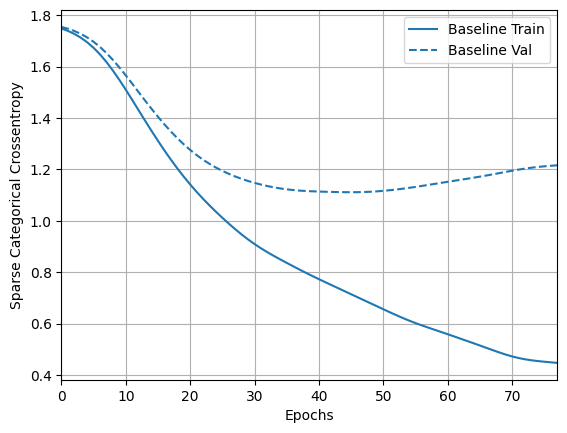

In [71]:
size_histories = {}
size_histories['Baseline'] = history
plotter = tfdocs.plots.HistoryPlotter(metric='sparse_categorical_crossentropy', smoothing_std=10)
plotter.plot(size_histories)

Let's also plot the training and validation accuracy values, to see how the model performs throughout the epochs.

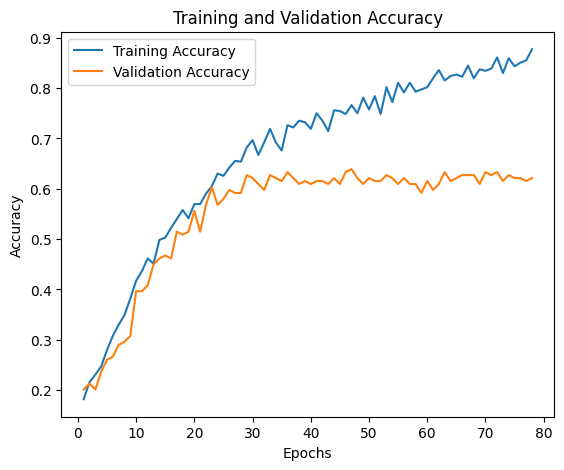

In [72]:
# Plot training & validation accuracy values
history_data = history.history

epochs = range(1, len(history_data['accuracy']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_data['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

We can see that the model the validation loss becomes stagnant after about 40 epochs.

Let's now evaluate the model on the test dataset.

In [32]:
model.evaluate(test_ds, verbose=1, batch_size=BATCH_SIZE)

7/7 [==============================] - 0s 1ms/step - loss: 1.0647 - accuracy: 0.6840 - sparse_categorical_crossentropy: 1.0440


[1.0646954774856567, 0.6839622855186462, 1.0439884662628174]

Let's also generate a classification report for the model along with the confusion matrix.

In [33]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

7/7 [==============================] - 0s 833us/step
              precision    recall  f1-score   support

           0       0.64      0.65      0.64        43
           1       0.73      0.71      0.72        31
           2       0.85      0.68      0.75        34
           3       0.52      0.62      0.56        26
           4       0.57      0.63      0.60        27
           5       0.78      0.76      0.77        51

    accuracy                           0.68       212
   macro avg       0.68      0.67      0.67       212
weighted avg       0.70      0.68      0.69       212

[[28  0  2  6  2  5]
 [ 2 22  1  1  3  2]
 [ 3  4 23  2  1  1]
 [ 5  1  0 16  3  1]
 [ 2  1  0  5 17  2]
 [ 4  2  1  1  4 39]]


We can see that the model has an accuracy of 0.68, which is not bad considering the small dataset we have.

However, we can see that the model is overfitting the training data, as the validation loss becomes higher than the training loss quickly,
which makes sense given the small dataset we have.

Ironically, the simpler models such as SVM and SGD outperformed the neural network model.

### Two-Level Classification

As we saw from before, we got the best results using the SGD Classifier.

Let's now try to perform a two-level classification, where we first classify the class of the word and then classify the division/section of the word based on the class it belongs to.

Firstly, we will create a new column in the dataframe named division/section, 
where it has as value the division if the division is not 4 (meaning `N/A` in our case),
 otherwise it has the value of the section.

Then we will split the data into training and testing sets, using 80% of the data for training and 20% for testing.

In [21]:
# For the cls_df dataframe create a new column named division/section where it has as value the division if the division is not 4, otherwise it has the value of the section
cls_df['division/section'] = cls_df['division']

# 4 Means No Division and this is evident if we take a look at the dataset
cls_df.loc[cls_df['division'] == 4, 'division/section'] = cls_df['section']

Now let's split the data into training and testing sets, using 80% of the data for training and 20% for testing.

In [22]:
# Get class and division/section
y = cls_df[['class', 'division/section']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11234)

Having done that we can now approach the two-level classification using the SGD Classifier as before, but this
time we will use the `MultiOutputClassifier` from sklearn to perform the multi-output classification.
However, there is a drawback to this approach, because at present, no metric in sklearn.metrics supports the multiclass-multioutput classification task.
This means that we will have to create our own custom accuracy metric for the multi-output classification.

In [23]:
# Create a multi-output classifier
multi_output_model = MultiOutputClassifier(
    sgd_model, n_jobs=-1)

# Train the multi-output classifier
multi_output_model.fit(X_train, y_train)

# Generate classification report
y_pred = multi_output_model.predict(X_test)

# Custom accuracy for multi-output
def multioutput_accuracy(y_true, y_pred):
    correct = np.all(y_true == y_pred, axis=1)
    return np.mean(correct)

accuracy = multioutput_accuracy(y_test, y_pred)
print(f"Multi-output Accuracy: {accuracy}")

Multi-output Accuracy: 0.5377358490566038


We can see that the multi-output accuracy is 0.538 which is not bad considering the small dataset we have,
however, it is not as good as the single-output classification we performed earlier.
Also, the custom accuracy metric we created may not be the best way to evaluate the multi-output classification.

For that reason, let's also look at the accuracy of each target separately.

In [26]:
for i in range(y_test.shape[1]):
    # Use .iloc to select all rows and the ith column for both Y_test and predictions
    accuracy = metrics.accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Target {i} accuracy: {accuracy}")

Target 0 accuracy: 0.7169811320754716
Target 1 accuracy: 0.589622641509434


We can see that the accuracy of the first target (class) is around 0.716, which is the same as the single-output classification we performed earlier,
however, the accuracy of the second target (division/section) is around 0.589, which is not as good as the single-output classification we performed earlier.